### Process & Store Datasets

#### 1. Get Data

Read data from text files as dataframes. Rebuild data and replace original columns with:
- sequence --> subsequences by [k-mer](https://en.wikipedia.org/wiki/K-mer#:~:text=Usually%2C%20the%20term%20k%2Dmer,total%20possible%20k%2Dmers%2C%20where) (k=5)
- class --> label declaring organism & class (e.g. human: 0)

In [2]:
import numpy as np
import pandas as pd

# Function to get k-mers for sequence s
def build_kmers(s, k):
    kmers = []
    n = len(s) - k + 1

    for i in range(n):
        kmer = s[i : i+k].upper()
        kmers.append(kmer)

    return kmers

# Function to replace sequence column with kmers in df
def seq_to_kmers(df):
    df['kmers'] = df.apply(lambda x: build_kmers(x['sequence'], 4), axis =1)
    df = df.drop(['sequence'],axis=1)


# Read files
human = pd.read_table('./data/human_data.txt')
chimp = pd.read_table('./data/chimp_data.txt')
dog = pd.read_table('./data/dog_data.txt')

# Replace classes with labels (organism: class)
human['label']=['human: ' + str(x) for x in human['class']]
human = human.drop(['class'], axis=1)

seq_to_kmers(human)
print(human.head())

                                            sequence     label  \
0  ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...  human: 4   
1  ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...  human: 4   
2  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...  human: 3   
3  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...  human: 3   
4  ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...  human: 3   

                                               kmers  
0  [ATGC, TGCC, GCCC, CCCC, CCCA, CCAA, CAAC, AAC...  
1  [ATGA, TGAA, GAAC, AACG, ACGA, CGAA, GAAA, AAA...  
2  [ATGT, TGTG, GTGT, TGTG, GTGG, TGGC, GGCA, GCA...  
3  [ATGT, TGTG, GTGT, TGTG, GTGG, TGGC, GGCA, GCA...  
4  [ATGC, TGCA, GCAA, CAAC, AACA, ACAG, CAGC, AGC...  


In [3]:
# Get lists of sequences in k-mers and labels in text from dataframe
def mydata(df):
    texts = []
    labels = []
    words = list(df['kmers']) # list of all sequences in kmers

    for i in range(len(words)):
        texts.append(' '.join(words[i])) 
    
    for x in df['label']:
        labels.append(x)

    if len(texts)!=len(labels):
        raise Exception("Texts & labels length are not equal!")
        
    return (texts, labels)
    
X, y = mydata(human)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("train row count:", len(X_train))
print("test row count:", len(X_test))

train row count: 2903
test row count: 726


#### 2. Generate Embeddings

Extract features for DNA sequences (after k-mers) by `CountVectorizer` with previously declared dimension. Normalize output by `sklearn.preprocessing` to get final embeddings.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

# Transform sequences in kmers to vectors
def char_to_vec(v_model, text):
    V = v_model.transform(text).toarray()
    #features = vectorizer.get_feature_names()
    embeddings = preprocessing.normalize(V)
    return embeddings

# Train vectorizer model 
vectorizer = CountVectorizer(ngram_range=(4,4), max_features=768)
X = vectorizer.fit_transform(X_train).toarray()
train_emb = list(preprocessing.normalize(X))
# print(vectorizer.get_feature_names())

human_emb = list(train_emb)
len(human_emb)

2903

#### 1. Classify DNA Sequences

The aim is to classify 20 human DNA sequences with labels. Inputs are pre-processed subsequences in text by k-mers (k=4).

Transform each input to vector with pre-trained vectorizer model.

In [5]:
def get_vector(text, vectorizer):
    x = vectorizer.transform(text).toarray()
    return list(preprocessing.normalize(x))

test_emb = get_vector(X_test, vectorizer)

In [6]:
from sklearn.metrics import accuracy_score

def classify_test(classifier, train_X, train_y, test_X):
    classifier.fit(train_X, train_y)
    y_pred = classifier.predict(test_X)
    return y_pred

In [7]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB

clf_svm = svm.SVC()
clf_neigh = KNeighborsClassifier(n_neighbors=1)
clf_centroid = NearestCentroid()
clf_tree = tree.DecisionTreeClassifier()
clf_mnb = MultinomialNB()

In [8]:
import time

x_axis = []
y_time = []
y_accuracy = []

start_time = time.time()
print("\nSVM:")
y_pred = classify_test(clf_svm, human_emb, y_train, test_emb)
end_time = time.time()
print("time elapsed = %.4fs" % (end_time - start_time))
print("accuracy = %.4f" % accuracy_score(y_test, y_pred))
x_axis.append('SVM')
y_time.append(end_time - start_time)
y_accuracy.append(accuracy_score(y_test, y_pred))

start_time = time.time()
print("\nKNN:")
y_pred = classify_test(clf_neigh, human_emb, y_train, test_emb)
end_time = time.time()
print("time elapsed = %.4fs" % (end_time - start_time))
print("accuracy = %.4f" % accuracy_score(y_test, y_pred))
x_axis.append('KNN')
y_time.append(end_time - start_time)
y_accuracy.append(accuracy_score(y_test, y_pred))

start_time = time.time()
print("\nNearestCentroid:")
y_pred = classify_test(clf_centroid, human_emb, y_train, test_emb)
end_time = time.time()
print("time elapsed = %.4fs" % (end_time - start_time))
print("accuracy = %.4f" % accuracy_score(y_test, y_pred))
x_axis.append('NearestCentroid')
y_time.append(end_time - start_time)
y_accuracy.append(accuracy_score(y_test, y_pred))

start_time = time.time()
print("\nDecisionTree:")
y_pred = classify_test(clf_tree, human_emb, y_train, test_emb)
end_time = time.time()
print("time elapsed = %.4fs" % (end_time - start_time))
print("accuracy = %.4f" % accuracy_score(y_test, y_pred))
x_axis.append('DecisionTree')
y_time.append(end_time - start_time)
y_accuracy.append(accuracy_score(y_test, y_pred))

start_time = time.time()
print("\nMultinominalNB:")
y_pred = classify_test(clf_mnb, human_emb, y_train, test_emb)
end_time = time.time()
print("time elapsed = %.4fs" % (end_time - start_time))
print("accuracy = %.4f" % accuracy_score(y_test, y_pred))
x_axis.append('MultinominalNB')
y_time.append(end_time - start_time)
y_accuracy.append(accuracy_score(y_test, y_pred))


SVM:
time elapsed = 3.9249s
accuracy = 0.8526

KNN:
time elapsed = 0.0759s
accuracy = 0.8691

NearestCentroid:
time elapsed = 0.0274s
accuracy = 0.5606

DecisionTree:
time elapsed = 0.6049s
accuracy = 0.6350

MultinominalNB:
time elapsed = 0.0138s
accuracy = 0.5716


In [9]:
from pymilvus_orm import *
import pymysql

connections.connect(host='localhost', port='19530')
conn = pymysql.connect(host='localhost', user='root', port=3306, password='123456', database='mysql',local_infile=True)
cursor = conn.cursor()

import time

time.sleep(.1)

collection_name = "dna_test"
dim = 768

# Drop the previously stored collection for a clear run
if utility.has_collection(collection_name) == True:
    collection = Collection(collection_name)
    collection.drop()

# Set fields & schema
all_fields = [
        schema.FieldSchema(name="pk", dtype=DataType.INT64, is_primary=True),
        schema.FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=dim)
        #schema.FieldSchema(name="class", dtype=DataType.STRING)
        ]
default_schema = schema.CollectionSchema(fields=all_fields, 
                                         description="DNA recognition: kmers & vectorizer", 
                                         auto_id=False)

# Create collection
DNA_collection = Collection(name=collection_name, data=None, schema=default_schema)

# Check if collection is successfully created
if utility.has_collection(collection_name):
    print(
    "Collection is successfully created: " + collection_name)
else:
    raise Exception("Fail to create collection: " + collection_name)
    
human_partition = DNA_collection.create_partition('human')

index_params = {
    'index_type': 'IVF_SQ8',
    'params': {'nlist': 512},
    'metric_type': 'IP'
    }

DNA_collection.create_index(field_name="embedding", index_params=index_params)

# Check if index is successfully set
if DNA_collection.has_index():
    print("Index is successfully set for collection " + collection_name)
else:
    raise Exception("Fail to set index for collection " + collection_name)
    
drop_table = "DROP TABLE IF EXISTS " + collection_name + ";"
cursor.execute(drop_table)

try:
    sql = "CREATE TABLE if not exists " + collection_name + " (pk TEXT, label TEXT);"
    cursor.execute(sql)
    print("create MySQL table successfully!")
except Exception as e:
    print("can't create a MySQL table: ", e)

Collection is successfully created: dna_test
Index is successfully set for collection dna_test
create MySQL table successfully!


In [10]:
import os
    
human_pk = [x for x in range(len(human_emb))]

if DNA_collection.num_entities == 0:
    DNA_human = DNA_collection.insert([human_pk, human_emb], partition_name='human')
    if DNA_collection.is_empty:
        print("Insert collection failed.")
    else:
        print(DNA_collection.partitions)
else:
    print("Previous data in this collection!")

# Combine pk and label into a list
def format_data(pk, label):
    data = []
    for i in range(len(pk)):
        value = (str(pk[i]), label[i])
        data.append(value)
    return data

def load_data_to_mysql(cursor, conn, table_name, data):
    sql = "insert into " + table_name + " (pk,label) values (%s,%s);"
    try:
        cursor.executemany(sql, data)
        conn.commit()
        print("MYSQL loads data to table: {} successfully".format(table_name))
    except Exception as e:
        print("MYSQL ERROR: {} with sql: {}".format(e, sql))

load_data_to_mysql(cursor, conn, collection_name, format_data(human_pk, y_train))

[{"name": "_default", "description": "", "num_entities": 0}, {"name": "human", "description": "", "num_entities": 2903}]
MYSQL loads data to table: dna_test successfully


In [11]:
DNA_collection.load()
search_params = {"metric_type": "IP", "params": {"nprobe": 20}}

def get_label_by_pk(cursor, m_pk, table_name):
    sql = "select label from " + table_name + " where pk=" + str(m_pk) +";"
    try:
        cursor.execute(sql)
        myresult = cursor.fetchall()
        myresult = [x[0] for x in myresult]
        return myresult
    except Exception as e:
        print("MYSQL ERROR: {} with sql: {}".format(e, sql))

In [12]:
start_time = time.time()
print("\nMilvus+Mysql:")
res = DNA_collection.search(test_emb, "embedding", search_params, limit=1, partition_names=['human'])
mil_res = []
for i in range(len(res)):
    for x in res[i]:
        C = get_label_by_pk(cursor, str(x.id), collection_name)
        for x in C:
            mil_res.append(x)
end_time = time.time()
print("time elapsed = %.4fs" % (end_time - start_time))
print("accuracy = %.4f" % accuracy_score(y_test, mil_res))
x_axis.append('Milvus+Mysql')
y_time.append(end_time - start_time)
y_accuracy.append(accuracy_score(y_test, mil_res))


Milvus+Mysql:
time elapsed = 3.2759s
accuracy = 0.9077


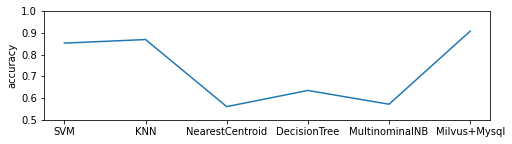

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 2))
plt.ylabel('accuracy')
plt.ylim([0.5,1])
plt.plot(x_axis, y_accuracy)